Predicting Phishing Attempts Using URL Composition
===

This notebook serves as a first iteration of attempting prediction of phishing attempts using only the values within a given URL. Much of the initially acquired data contains values that pertain to the HTML analysis of the web pages the URLs reference, this data will not be used in this initial iteration. The initial understand and hypothesis of the data was that longer URLs with higher number of special characters, particularly hyphens and dots, would be more likely phishing attempts than not. 

⏯ Initialize Notebook

In [1]:
# import standard libraries
import pandas as pd
import numpy as np

# import visualization
import matplotlib.pyplot as plt
import seaborn as sns

# import statistical testing
import scipy.stats as stats

# import created modules
import prepare as pp
import explore as ex

# cosmetic settings
import warnings
warnings.filterwarnings("ignore")
from matplotlib.pyplot import style
style.use('~/.matplotlib/gruvbox.mplstyle')

## Data Acquisition

---

In [2]:
# read in CSV to DataFrame
df = pd.read_csv('phishing.csv')

In [3]:
# inspect first two rows
df.head(2)

,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
0,1,3,1,5,72,0,0,0,0,0,...,0,0,1,1,0,1,1,-1,1,1
1,2,3,1,3,144,0,0,0,0,2,...,0,0,0,1,-1,1,1,1,1,1


In [4]:
# check .info()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  10000 non-null  int64  
 1   NumDots                             10000 non-null  int64  
 2   SubdomainLevel                      10000 non-null  int64  
 3   PathLevel                           10000 non-null  int64  
 4   UrlLength                           10000 non-null  int64  
 5   NumDash                             10000 non-null  int64  
 6   NumDashInHostname                   10000 non-null  int64  
 7   AtSymbol                            10000 non-null  int64  
 8   TildeSymbol                         10000 non-null  int64  
 9   NumUnderscore                       10000 non-null  int64  
 10  NumPercent                          10000 non-null  int64  
 11  NumQueryComponents                  10000 

### Acquire Summary

- No null values present in data set
- Column naming scheme obfuscates meaning or is difficult to parse
    - Names will be adjusted to more clearly reflect meaning where needed
- Many variables correspond to HTML elements of web page
    - Focus of initial product is to predict based on data available from URL prior to clicking
    - Non-URL data will be dropped for exploration toward this goal

## Data Preparation
---

In [5]:
# create variable to hold list of URL specific columns
col_list = [
    'NumDots', 'SubdomainLevel', 'PathLevel',
    'UrlLength', 'NumDash', 'NumDashInHostname',
    'AtSymbol', 'TildeSymbol', 'NumUnderscore',
    'NumPercent', 'NumQueryComponents', 'NumAmpersand',
    'NumHash', 'NumNumericChars', 'NoHttps',
    'RandomString', 'DomainInSubdomains', 'DomainInPaths',
    'HttpsInHostname', 'HostnameLength', 'PathLength',
    'QueryLength', 'DoubleSlashInPath', 'NumSensitiveWords',
    'CLASS_LABEL']

# create dictionary for column name changes
rename_dict = {
    'NumDots':'num_dot_url',
    'SubdomainLevel':'subdomain_level',
    'PathLevel':'path_level',
    'UrlLength':'url_char_length',
    'NumDash':'num_dash_url',
    'NumDashInHostname':'num_dash_hostname',
    'AtSymbol':'has_at_symbol',
    'TildeSymbol':'has_tilde',
    'NumUnderscore':'num_underscore_url',
    'NumQueryComponents':'num_queries',
    'NumAmpersand':'num_ampersand',
    'NumHash':'num_hash',
    'NumNumericChars':'num_numerics',
    'NoHttps':'not_https',
    'RandomString':'has_random_string',
    'DomainInSubdomains':'domain_in_subdomain',
    'DomainInPaths':'domain_in_path',
    'HttpsInHostname':'https_in_hostname',
    'HostnameLength':'hostname_length',
    'PathLength':'path_length',
    'QueryLength':'query_length',
    'DoubleSlashInPath':'doubleslash_in_path',
    'NumSensitiveWords':'num_sensitive_words',
    'CLASS_LABEL':'is_phishing_attempt'}


In [6]:
# filter to desired columns and rename
df = df[col_list]
df = df.rename(columns=rename_dict)

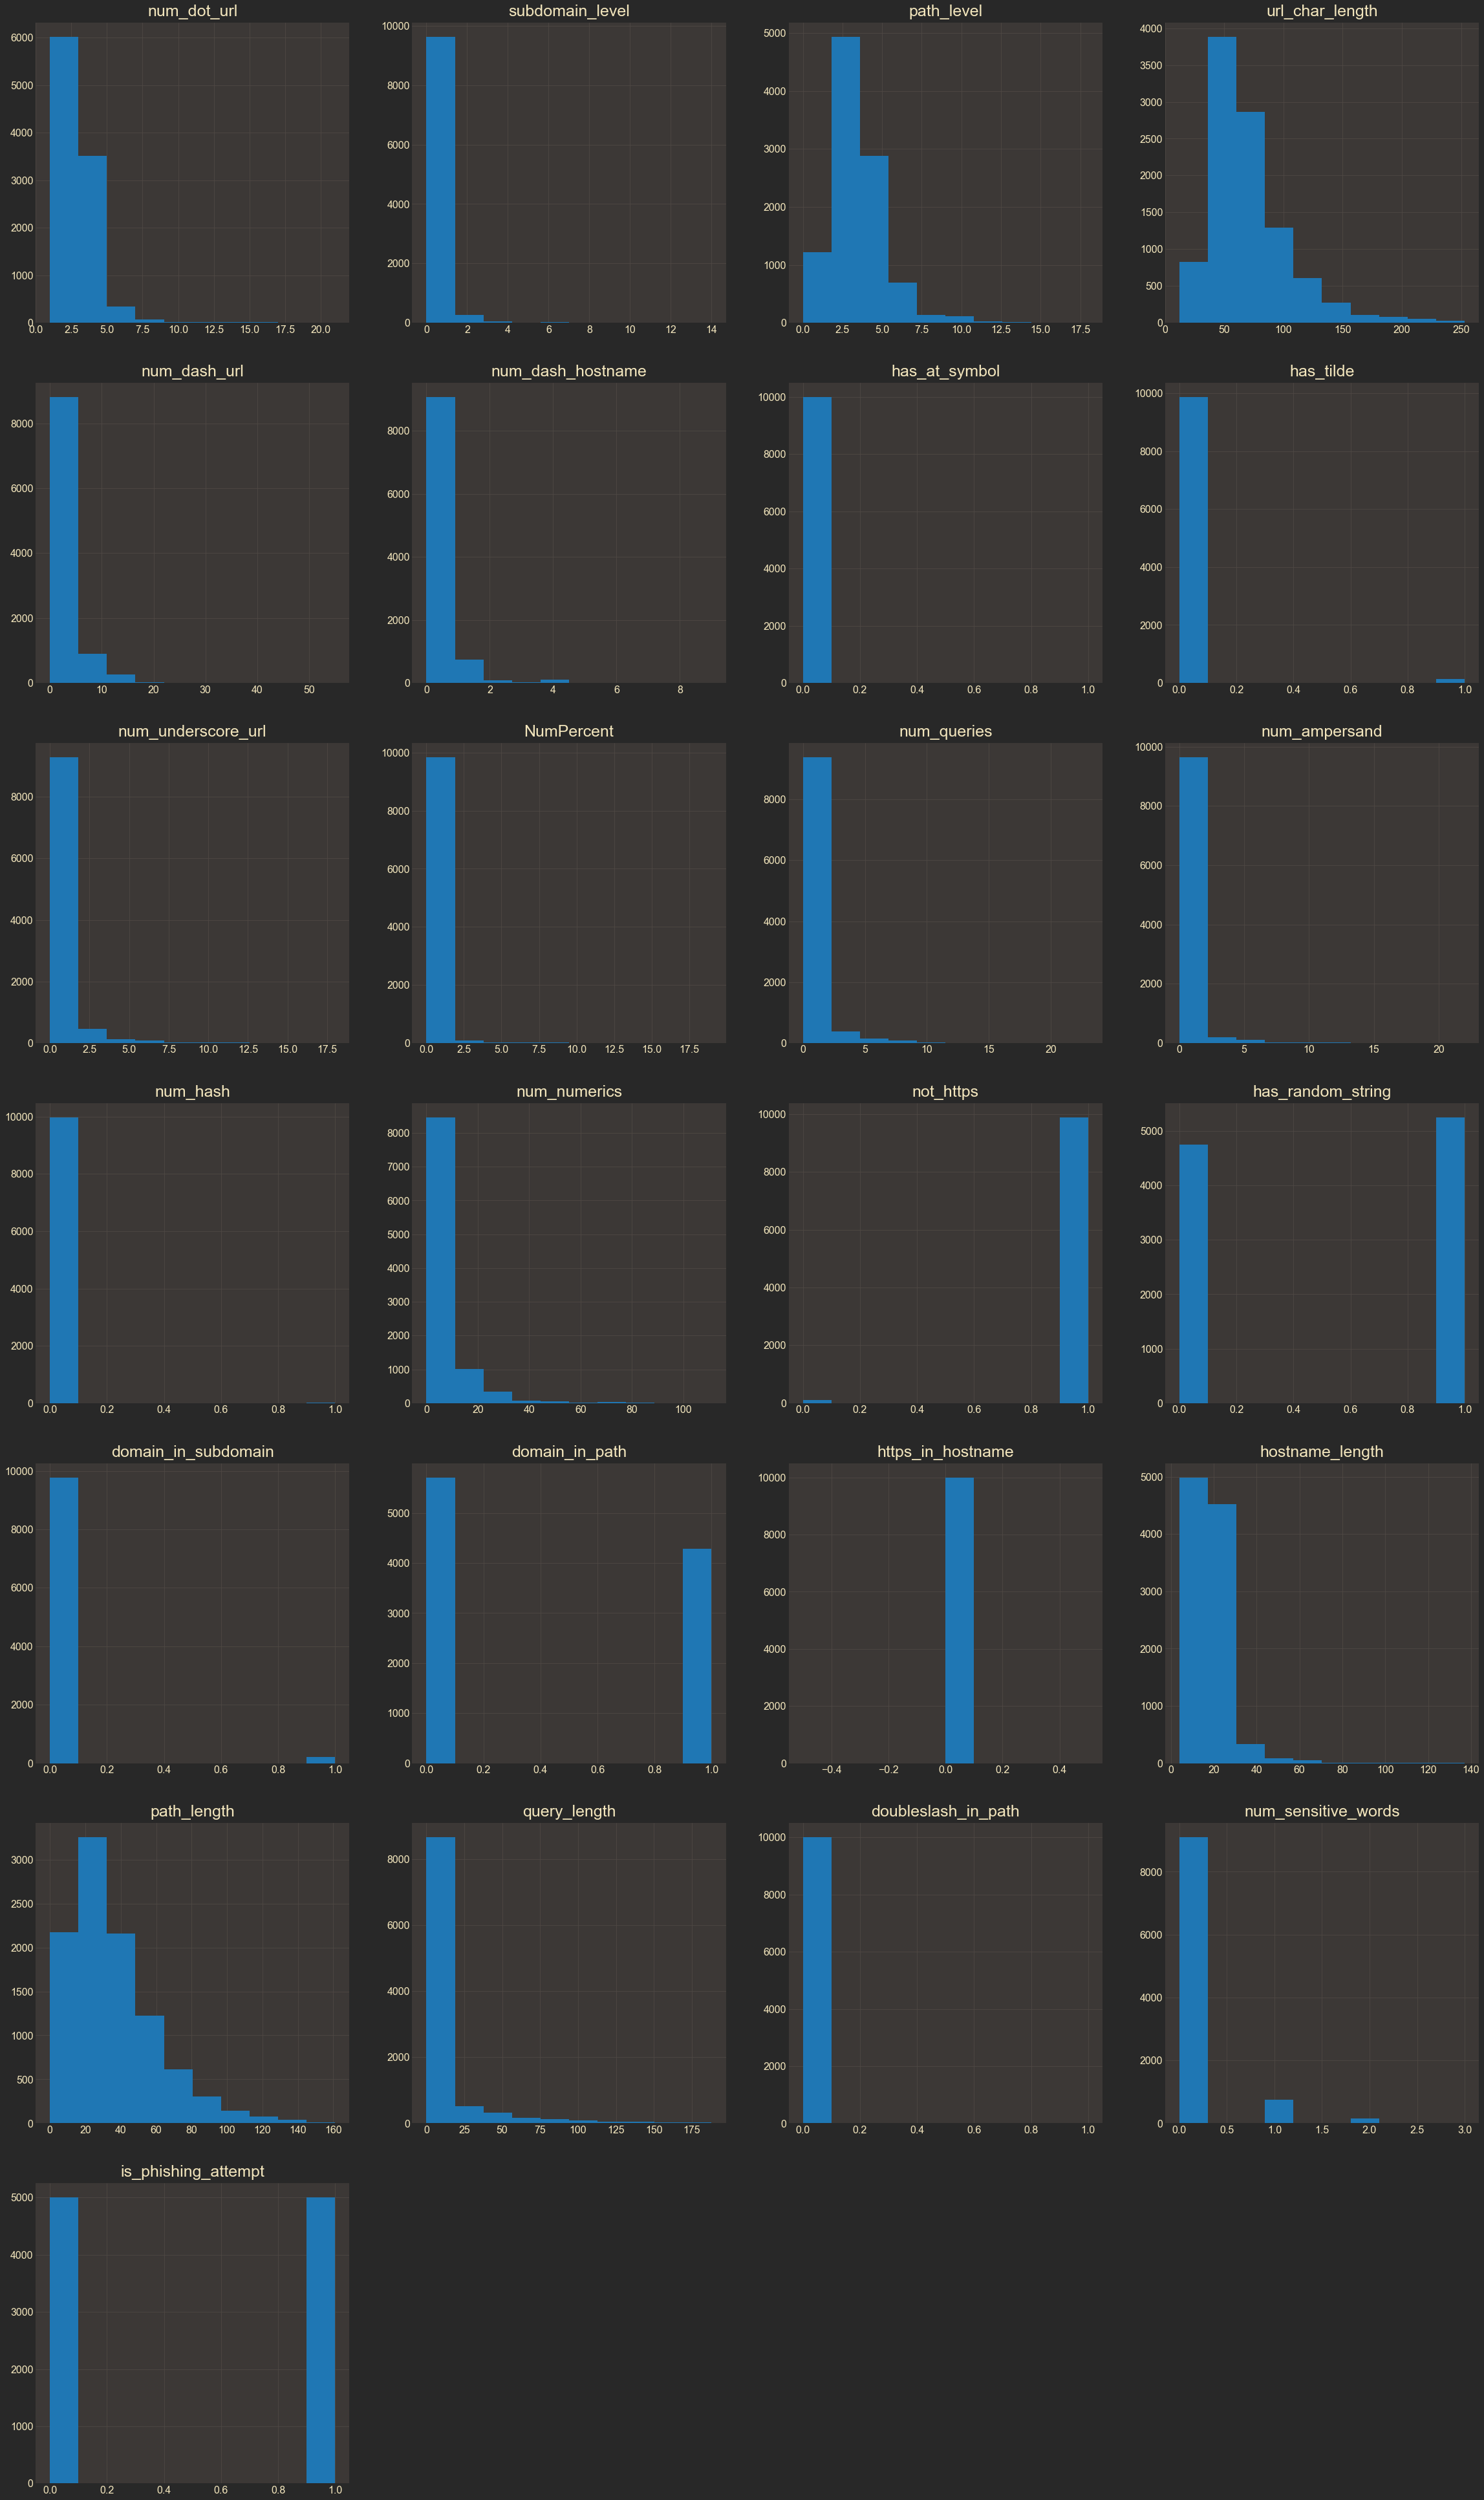

In [7]:
# plot distributions of variables
from math import ceil
nrows = ceil(len(df.columns) / 4)
plt.figure(figsize=(40, nrows * 10))
for n, col in enumerate(df.columns):
    plt.subplot(nrows, 4, n + 1)
    plt.title(f'{df[col].name}', fontsize=25, pad=10)
    plt.hist(df[col])

In [8]:
# check value counts for questionable distributions
df.https_in_hostname.value_counts(), \
df.has_at_symbol.value_counts(), \
df.num_hash.value_counts(), \
df.doubleslash_in_path.value_counts()

(0    10000
 Name: https_in_hostname, dtype: int64,
 0    9997
 1       3
 Name: has_at_symbol, dtype: int64,
 0    9977
 1      23
 Name: num_hash, dtype: int64,
 0    9991
 1       9
 Name: doubleslash_in_path, dtype: int64)

In [9]:
# drop columns that provide insufficent value
df = df.drop(columns=['https_in_hostname', 'has_at_symbol',
                      'num_hash', 'doubleslash_in_path'])

### Prepare Summary

- Variable distributions shows some values approaching $100\%$ of the observations in one class over the other(s)
    - These may not offer insights into predicting phishing attempts
- `path_level`, `url_char_length`, and `path_length` are approximately normally distributed
- Most of the `num_` variables and `hostname_length` are strongly right skewed
    - It may be best to maintain these outliers rather than removing them

In [10]:
# split data in advance of exploration
train, validate, test = pp.split_data(df, stratify='is_phishing_attempt')

## Data Exploration
---

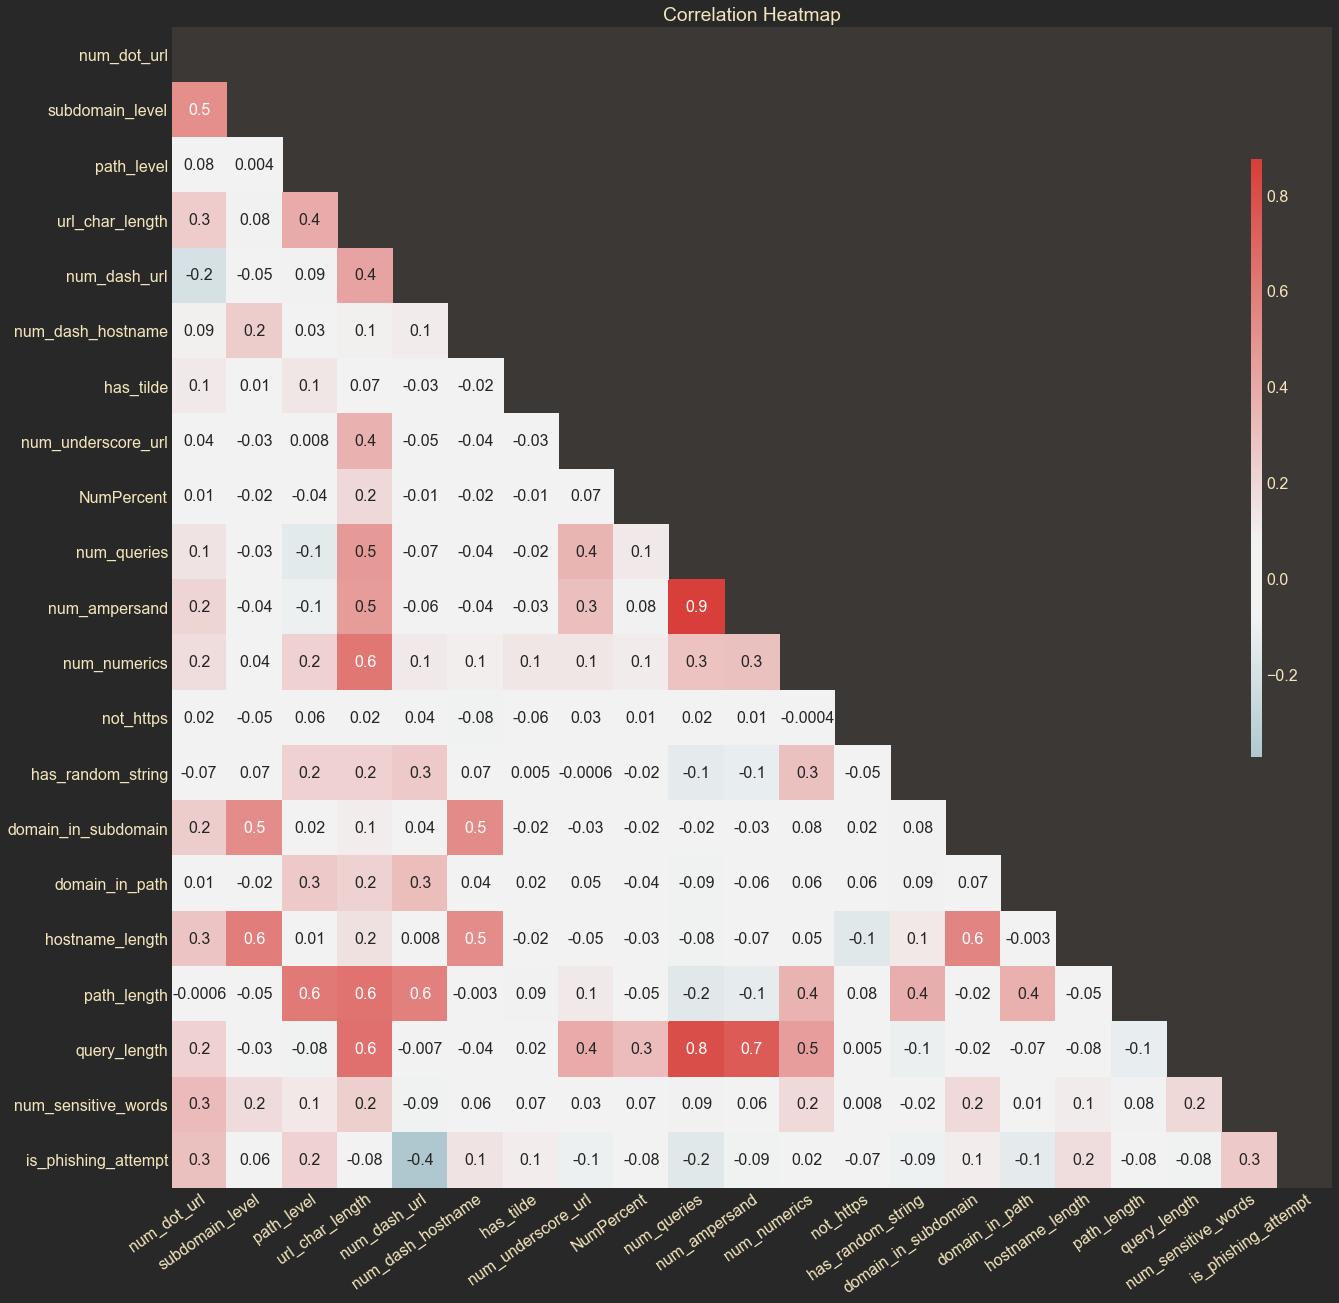

In [11]:
# plot heatmap of variable correlation
ex.plot_heat(train)

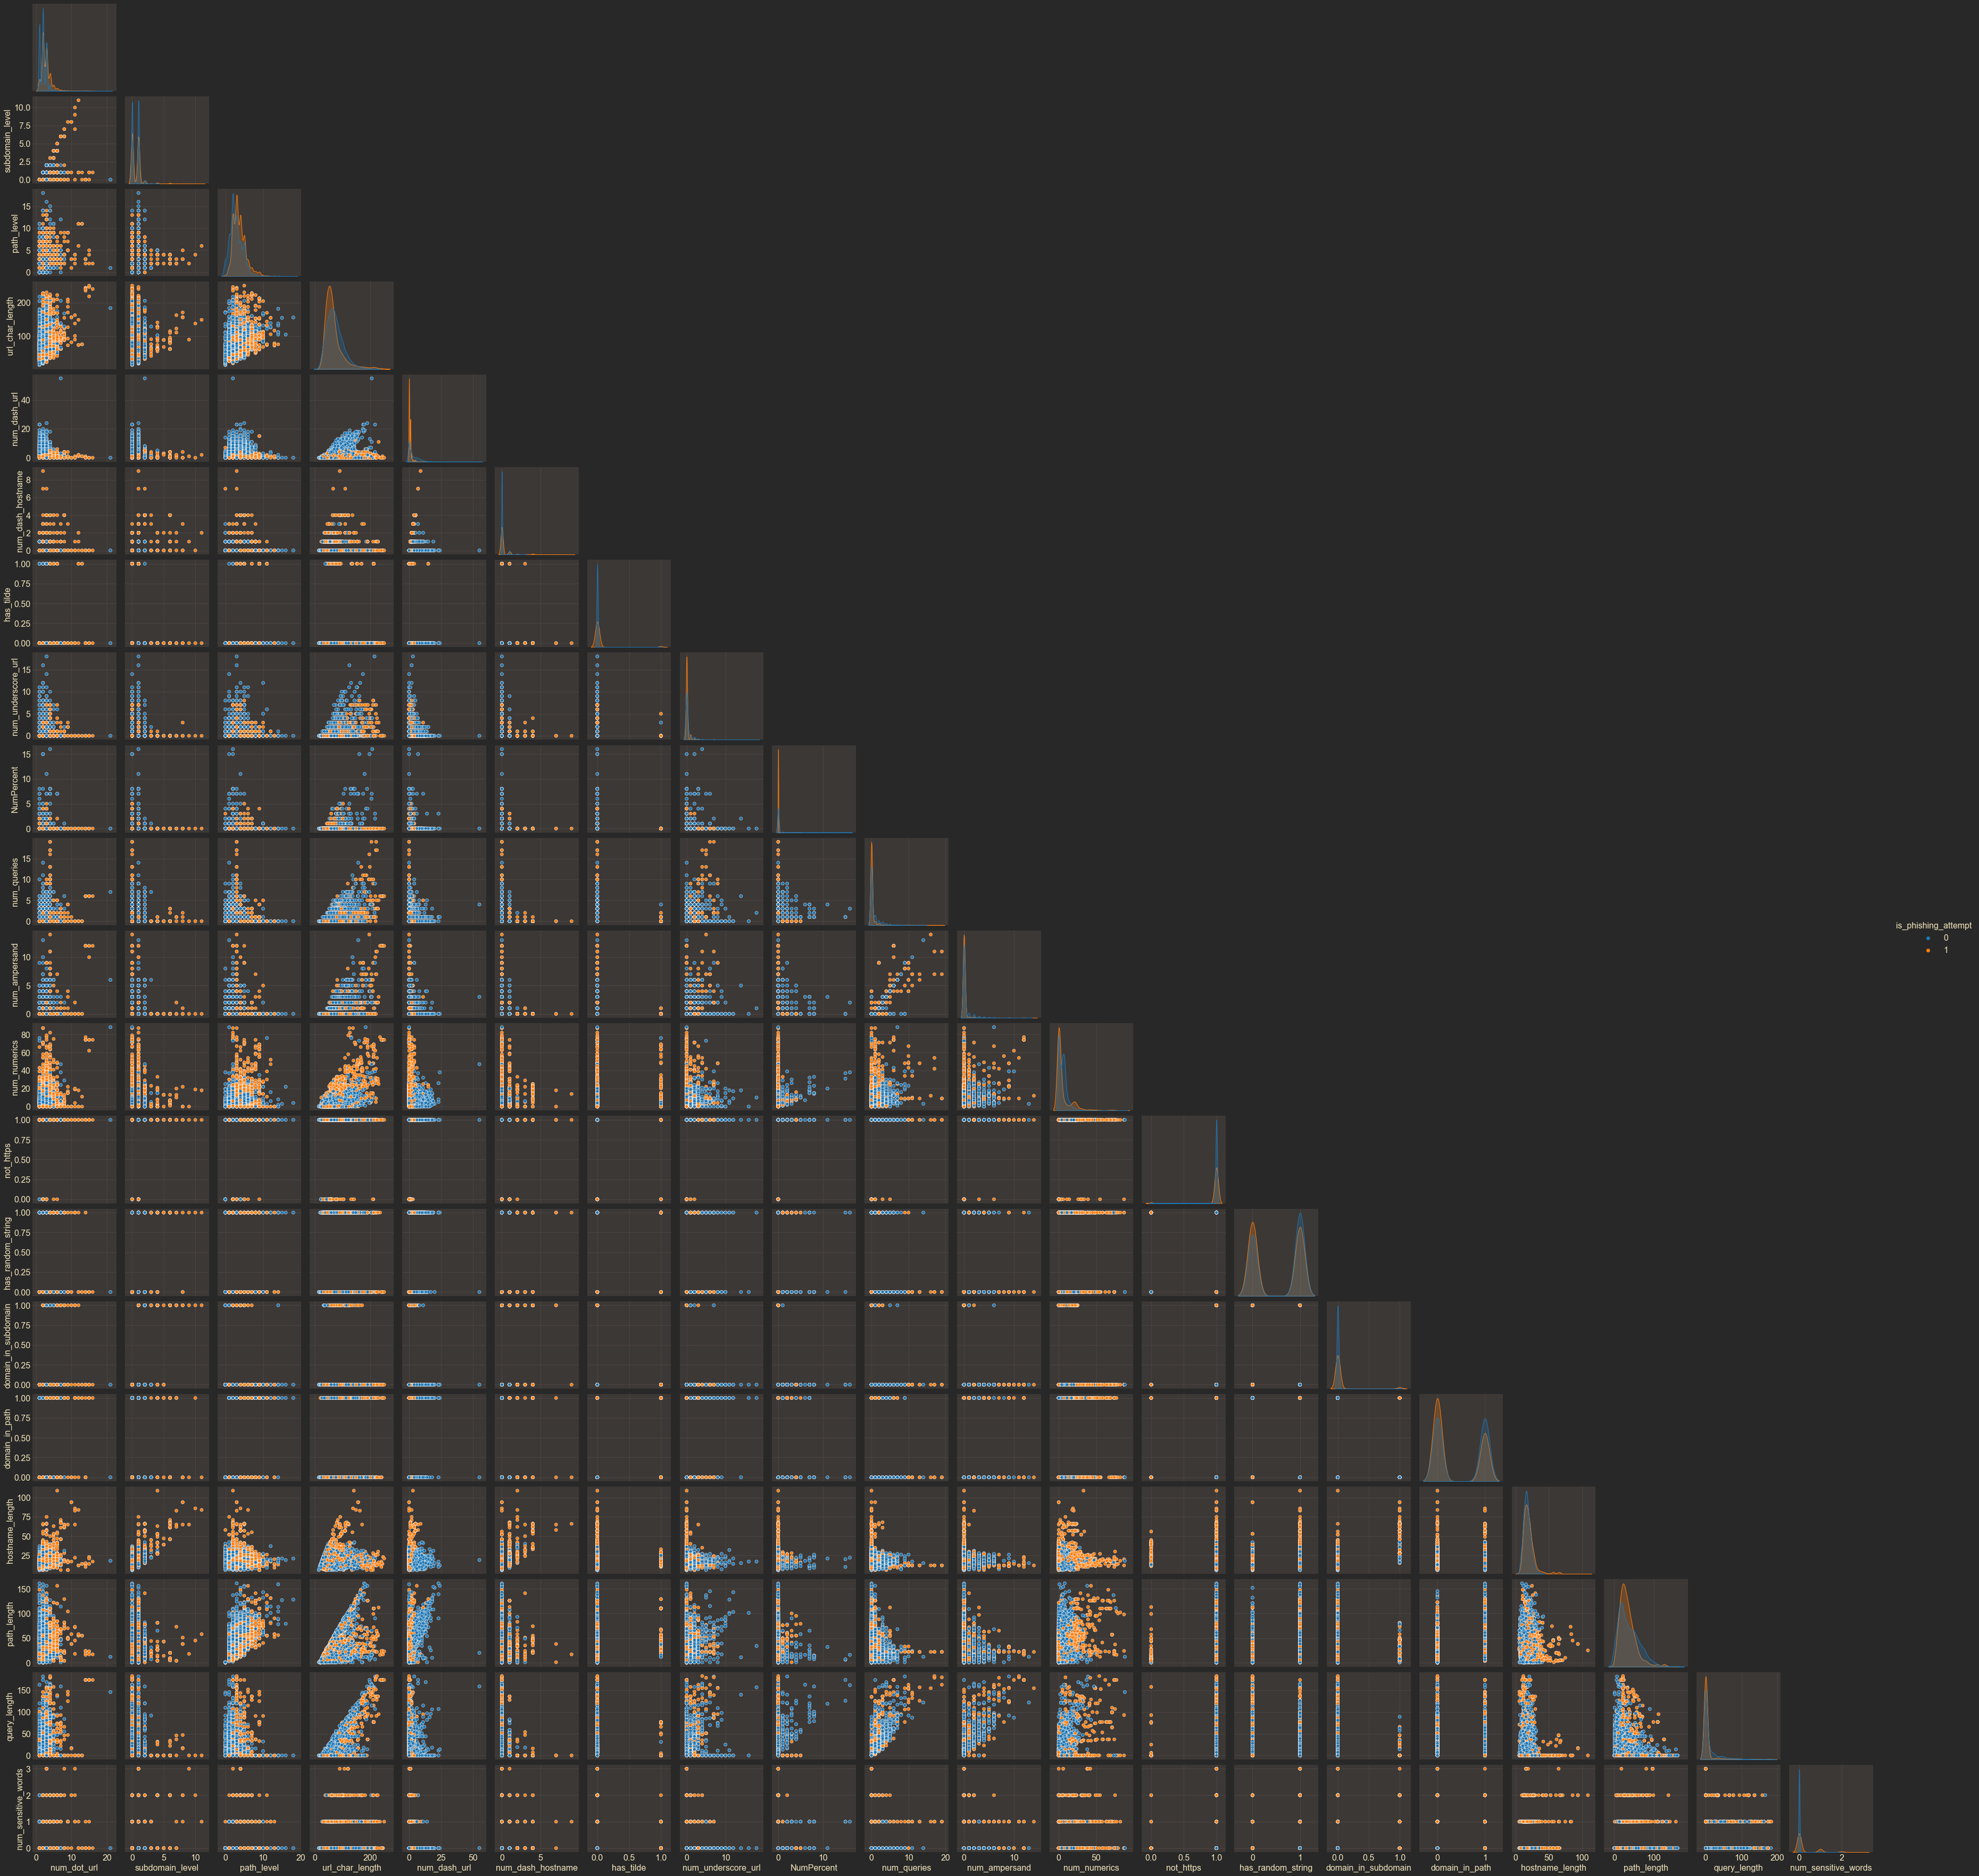

In [12]:
# plot pairplot to find any potential cluster formations
sns.pairplot(train, hue='is_phishing_attempt', corner=True)

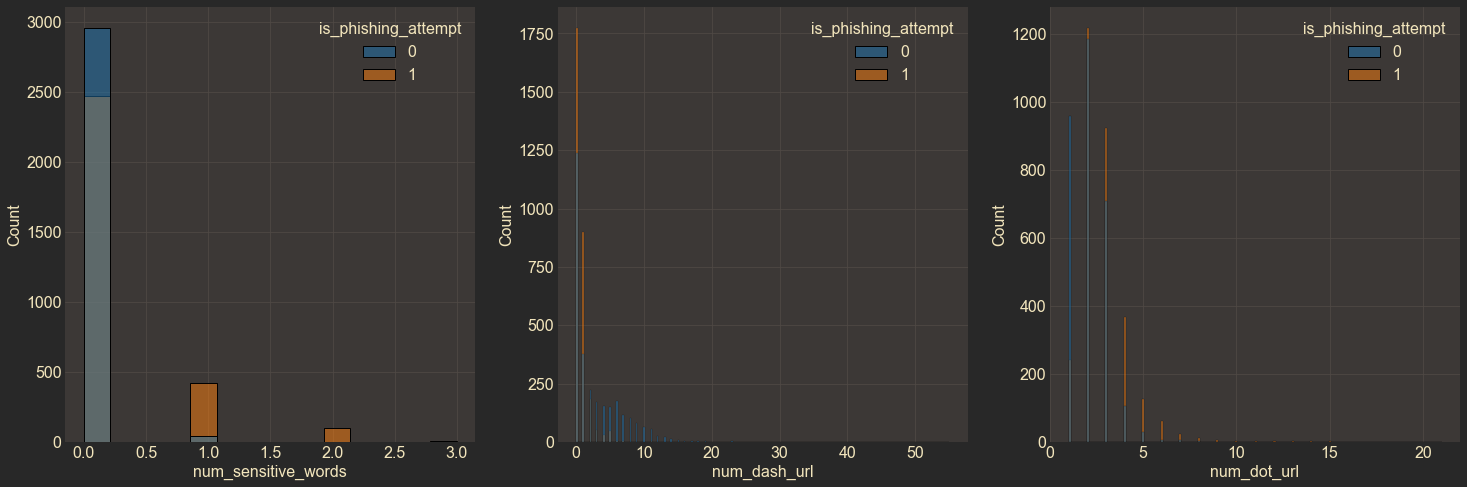

In [13]:
# plot distributions of variables with target hue
plt.subplot(1, 3, 1)
sns.histplot(train, x='num_sensitive_words', hue='is_phishing_attempt')
plt.subplot(1, 3, 2)
sns.histplot(train, x='num_dash_url', hue='is_phishing_attempt')
plt.subplot(1, 3, 3)
sns.histplot(train, x='num_dot_url', hue='is_phishing_attempt')
plt.show()

**Statistical Testing**
<br>
To evaluate the independence of theses variables to the target, a $\chi^2$ test will be peformed. 

- H$_0$: `is_phishing_attempt` is independent of the chosen variable.
- H$_a$: `is_phishing_attempt` is not independent of the chosen variable.
- $\alpha$: 0.05

In [14]:
# perform chi^2 test for desired variables
for cat in ['num_sensitive_words', 'num_dash_url', 'num_dot_url']:
    ex.chi_test_lite(train[cat], train.is_phishing_attempt)


  alpha: 0.05
p-value: 8e-98

        Due to our p-value of 8e-98 being less than our significance level of 0.05, we must reject the null hypothesis
        that is_phishing_attempt is independent of num_sensitive_words.
        

  alpha: 0.05
p-value: 8e-231

        Due to our p-value of 8e-231 being less than our significance level of 0.05, we must reject the null hypothesis
        that is_phishing_attempt is independent of num_dash_url.
        

  alpha: 0.05
p-value: 1e-150

        Due to our p-value of 1e-150 being less than our significance level of 0.05, we must reject the null hypothesis
        that is_phishing_attempt is independent of num_dot_url.
        


### Initial Takeaways

- Seemingly strong distinction in hue between `num_dash_url` and `num_dot_url`
    - Fewer dots were more likely to be legitimate
    - Fewer dashes were more likely to be phishing
    - Use clustering to create groups, maybe three, as a created feature
- The existence of any sensitive words, like "security" or "password", seem much more common in the target's positive class
- All three of the stand out variables rejected the null hypothesis in $\chi^2$ testing for independence from the target

### Cluster Exploration

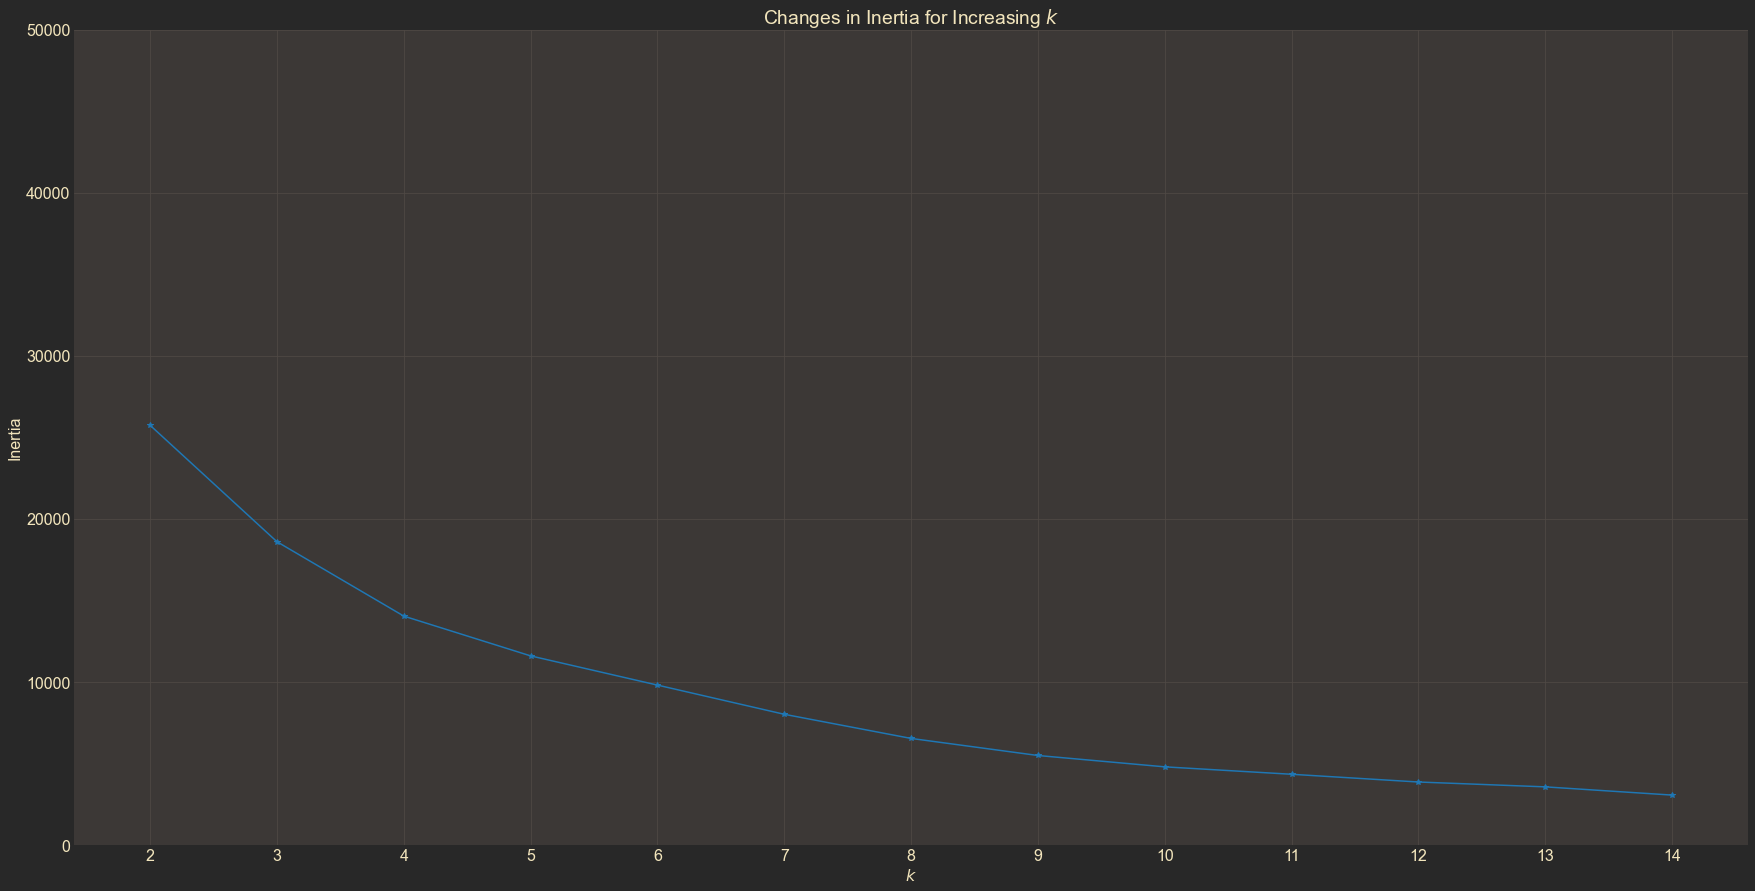

In [15]:
# use elbow plot method to find k optimal clusters
ex.elbow_plot(train, ['num_dash_url', 'num_dot_url'])

In [16]:
# create cluster for exploratory purpose
clusters, centers, _ = ex.explore_clusters(train,
                                ['num_dash_url', 'num_dot_url'], 3)

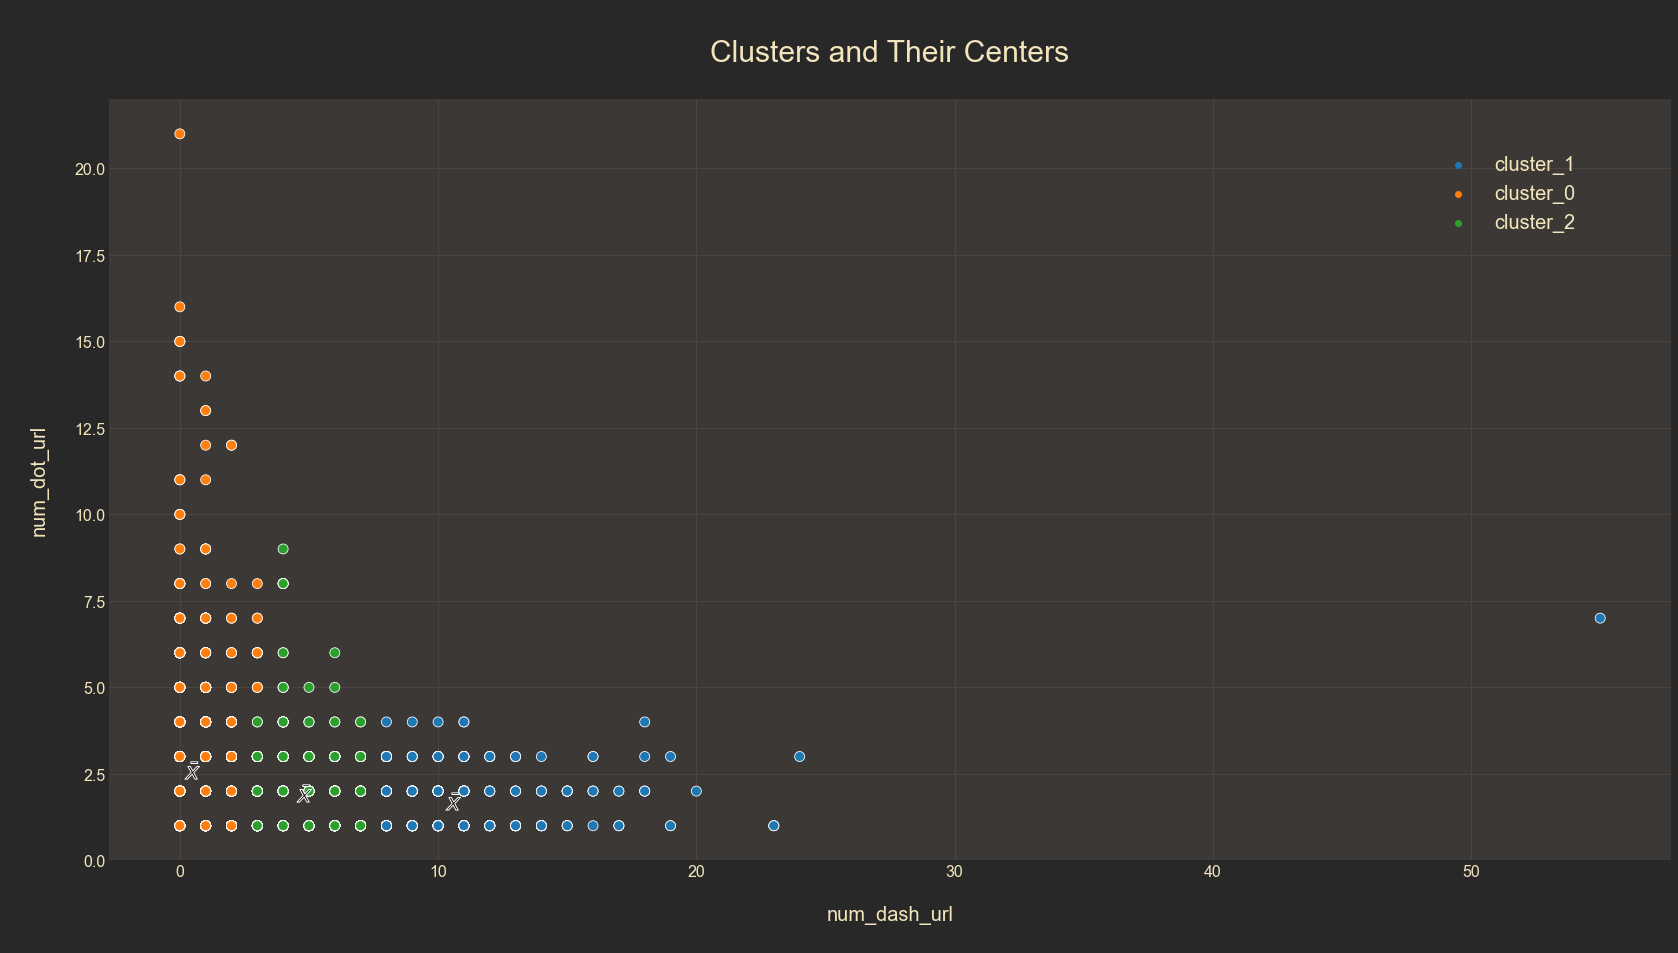

In [17]:
# plot clusters for visual of splits
ex.plot_clusters(clusters, centers, 'num_dash_url', 'num_dot_url')

**Statistical Test**
<br>
To test if there is a difference in the cluster samples from the population, an ANOVA test will be performed in place of multiple T-Tests to reduce likelihood of Type-I errors.

- H$_0$: The four clusters have the same mean as the population.
- H$_a$: The four clusters do not have the same mean as the population.
- $\alpha$: 0.05

In [18]:
# set alpha for testing significance
alpha = 0.05
# create DataFrame of samples for ANOVA testing
samples = pd.concat((clusters, train.is_phishing_attempt), axis=1)
# Perform ANOVA one-way test for null hypotesis
F, p = stats.f_oneway(samples[samples.cluster == 0].is_phishing_attempt,
                      samples[samples.cluster == 1].is_phishing_attempt,
                      samples[samples.cluster == 2].is_phishing_attempt)
# print fail or succeed to reject and values returned
if p < alpha:
    state = '✓ May reject'
else:
    state = '𐄂 Fail to reject'
print(f'''
      Stats
+---------------+
|  F-stat: {F:.0f}  |  {state}
| p-value: {p:.2f} |  the null hypothesis.
+---------------+
''')


      Stats
+---------------+
|  F-stat: 644  |  ✓ May reject
| p-value: 0.00 |  the null hypothesis.
+---------------+



**Results**
<br>
It seems the null hypothesis can be strongly rejected, indicating evidence of different means from the population for the clusters. They may have strong use as features in modeling.

In [19]:
# create clusters and encode them only train, validate, test
train, validate, test = ex.create_clusters(train, validate, test,
                        ['num_dash_url', 'num_dot_url'], 'dash_dot', 3)

### Exploration Summary
<br>
In the initial exploration phase, there are several key takeaways to document.

- Variables with the strongest correltations to the target are:
    - `num_dot_url`, Pearson $r\approx0.3$
    - `num_sensitive_words`, Pearson $r\approx0.3$
    - `num_dash_url`, Pearson $r\approx-0.4$
- Clustering of `num_dot_url` with `num_dash_url` may provide a usable feature in modeling
    - ANOVA testing of cluster samples rejected null hypothesis that sample means were the same as the population
- All three variables above rejected null hypothesis that there was no independence to target in $\chi^2$ test